In [1]:
#importation des bilbliothèques
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import sys
import requests
import zipfile
import gdown
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random
import pickle
from tqdm import tqdm
import shutil
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sn

In [2]:
#telechargement de la base et autres dossiers
url = "https://drive.google.com/uc?id=11fRyi7M1gr0b207UqagDGbPnXjNUsjGU"
output = "dataset.zip"
gdown.download(url, output, quiet=False)
#unzip file
!unzip "dataset.zip"

models_url ="https://drive.google.com/uc?id=1uDa0nsTbT_v4ypwff83NyqWlM294I1Vi"
output="models.zip"
gdown.download(models_url, output, quiet=False)
!unzip "models.zip"

Downloading...
From: https://drive.google.com/uc?id=11fRyi7M1gr0b207UqagDGbPnXjNUsjGU
To: /content/dataset.zip
100%|██████████| 131M/131M [00:01<00:00, 70.0MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: dataset/obj36__275.png  
  inflating: dataset/obj36__280.png  
  inflating: dataset/obj36__285.png  
  inflating: dataset/obj36__290.png  
  inflating: dataset/obj36__295.png  
  inflating: dataset/obj36__30.png   
  inflating: dataset/obj36__300.png  
  inflating: dataset/obj36__305.png  
  inflating: dataset/obj36__310.png  
  inflating: dataset/obj36__315.png  
  inflating: dataset/obj36__320.png  
  inflating: dataset/obj36__325.png  
  inflating: dataset/obj36__330.png  
  inflating: dataset/obj36__335.png  
  inflating: dataset/obj36__340.png  
  inflating: dataset/obj36__345.png  
  inflating: dataset/obj36__35.png   
  inflating: dataset/obj36__350.png  
  inflating: dataset/obj36__355.png  
  inflating: dataset/obj36__40.png   
  inflating: dataset/obj36__45.png   
  inflating: dataset/obj36__5.png    
  inflating: dataset/obj36__50.png   
  inflating: dataset/obj36__55.png   
  inflating: dataset/obj36__60.png   

Downloading...
From: https://drive.google.com/uc?id=1uDa0nsTbT_v4ypwff83NyqWlM294I1Vi
To: /content/models.zip
100%|██████████| 50.9M/50.9M [00:00<00:00, 97.0MB/s]


Archive:  models.zip
  inflating: models/sift_predictions.pickle  
  inflating: models/sift_test_descriptors.pickle  
  inflating: models/sift_train_descriptors.pickle  
  inflating: models/sift_true_labels.pickle  


In [3]:
#partage du dataset et creattion du dossier models
!mkdir "dataset/test"
!mkdir "dataset/train"
i=0
for filename in os.listdir("dataset"):
  if os.path.isfile("dataset/"+filename):
    if i==0:
      shutil.move("dataset/"+filename, "dataset/test")
      i=1
    else:
      shutil.move("dataset/"+filename, "dataset/train")
      i=0

In [4]:
#fonction de chargement des images d'entrainements et de tests
def load_data(dataset_directory):
    train_images= {}
    for filename in os.listdir(dataset_directory):
        #get path
        #current_folder=filename.split('_')[0]
        path_folder = dataset_directory
        #print(path_folder)
        # find the keypoints and descriptors with SIFT
        current_image=cv.imread(path_folder+filename);
        train_images[path_folder+filename]=current_image;
    return train_images;

In [5]:
#chargement des images d'entrainements et de tests
train_images=load_data("dataset/train/")
test_images= load_data("dataset/test/")
print("nombre total d'image d'entrainement")
print(len(train_images))
print("nombre total d'image de test")
print(len(test_images))

nombre total d'image d'entrainement
3600
nombre total d'image de test
3600


In [6]:
#fonction d'affichage des images
def display_images(train_images):      
  plt.figure(figsize=(10, 10))
  for i in range(10):
    key=random.choice(list(train_images.keys()))
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[key], cmap='gray')
    plt.title('Label: {}'.format(key.split('/')[2]))
    plt.axis("off")

affichage de quelques images


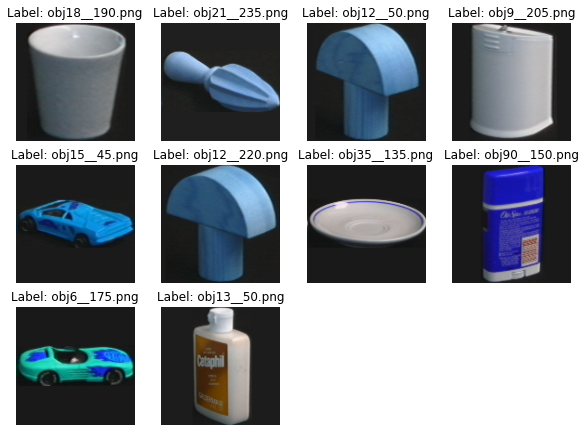

In [7]:
print("affichage de quelques images")
display_images(train_images)

In [8]:
#fonction de conversion d'image en gray
def convert_to_gray(train_images):
  train_gray_images={}
  for key in train_images:
    train_gray_images[key]=cv.cvtColor(train_images[key], cv.COLOR_RGB2GRAY)
  return train_gray_images

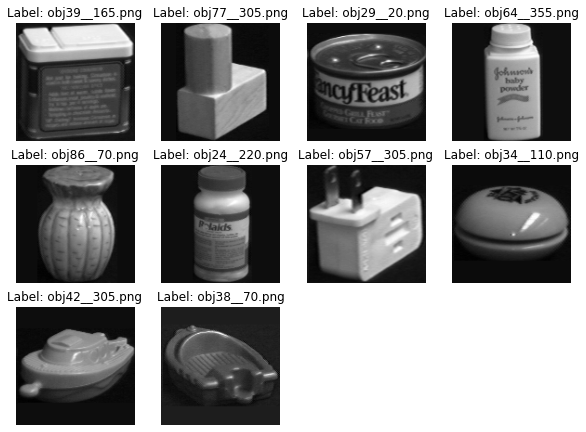

In [9]:
#convertion images de train et test en gray
train_gray_images=convert_to_gray(train_images)
test_gray_images=convert_to_gray(test_images)

#affichage des images de traitement en gray
display_images(train_gray_images)

In [10]:
#fonction de calcul de descripteurs
def describeImages(train_gray_images,train_images):
    sift = cv.SIFT_create()
    descriptors= {}
    keypoints={}
    draws={}
    with tqdm(total=len(train_images), desc="Calcul de descripteur", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
      for key in train_gray_images:
        current_kp, current_des = sift.detectAndCompute(train_gray_images[key],None)
        descriptors[key]=current_des;
        draws[key]=cv.drawKeypoints(train_gray_images[key], current_kp, train_images[key].copy(), flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        keypoints[key]=current_kp;
        pbar.update(1)
      return descriptors, keypoints,draws

In [11]:
#calcul de descripteurs de train et test images
#descripteur des images train
descriptors,keypoints,draws=describeImages(train_gray_images, train_images)
#descripteurs des images test
test_descriptors,test_keypoints,test_draws=describeImages(test_gray_images, test_images)

Calcul de descripteur: 100%|██████████ [ time left: 00:00 ]
Calcul de descripteur: 100%|██████████ [ time left: 00:00 ]


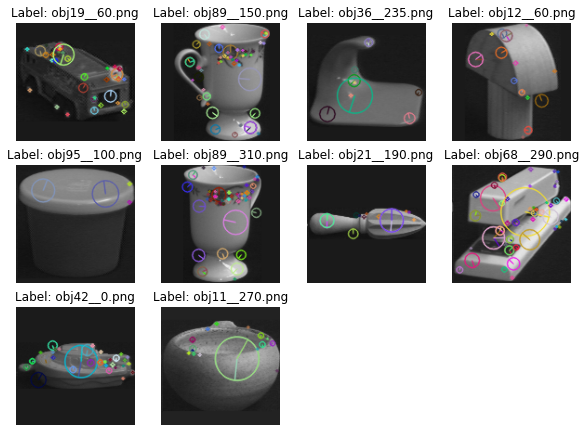

In [12]:
#affichage des descripteurs et images train
display_images(draws)

In [13]:
#affichage d'un descripteur
print(descriptors[list(descriptors)[0]])

[[  0.   0.   0. ...   0.   0.   3.]
 [  0.  10.  15. ...   0.   0.   0.]
 [  1.  95. 138. ...   0.   0.   0.]
 ...
 [  3.   0.   0. ...   1.  11.  80.]
 [ 19.   1.   0. ...   0.   0.   6.]
 [  0.   0.   0. ...  14.  14.  19.]]


In [14]:
#enregistrement des descripteurs train et test dans  un fichier
with open("models/sift_train_descriptors.pickle", "wb") as file:
    pickle.dump(descriptors, file, pickle.HIGHEST_PROTOCOL)
with open("models/sift_test_descriptors.pickle", "wb") as file:
    pickle.dump(test_descriptors, file, pickle.HIGHEST_PROTOCOL)

In [15]:
#chargement des descripteurs train et test
# laod a pickle file
with open("models/sift_train_descriptors.pickle", "rb") as file:
    descriptors = pickle.load(file)
with open("models/sift_test_descriptors.pickle", "rb") as file:
    test_descriptors = pickle.load(file)

In [16]:
#Fonction de match brute force
def my_match(descriptor1,descriptor2,seuil=0.60):
  bf= cv.BFMatcher()
  matches = bf.knnMatch(descriptor1,descriptor2,k=2)
  good = []
  #application ration pour déterminer les correspondances réussies
  for m,n in matches:
    if m.distance < seuil*n.distance:
        good.append([m])
  return good
#Fonction de calcul des similarités/scores sift en fonction de l'image test et du seuil
def get_similarities(kp_test,des_test,seuil=0.60):
  similarities={}
  #sift = cv.SIFT_create()
  bf = cv.BFMatcher()
  compteur=0
  #calcul des correspondances avec tous les descripteurs train
  for key in descriptors:
    try:
      #calcul rorrespondance brute force
      matches = bf.knnMatch(des_test,descriptors[key],k=2)
      good = []
      #application ration pour déterminer les correspondances réussies
      try:
        if(matches!=()):
          for m,n in matches:
            if m.distance < seuil*n.distance:
                good.append([m])
          #calcul et enregistrement des scores
          similarities[key]=(len(good)/len(matches))*100
        compteur+=1
      except:
        continue
    except:
      continue
  return similarities
#classons les similarités par ordre décroissant
def get_sorted_similarities(similarities,k=5):
  sorted_similiraties_values = sorted(similarities.values(), reverse=True)
  sorted_similarities = {}
  for i in sorted_similiraties_values:
      for k in similarities.keys():
          if similarities[k] == i:
              sorted_similarities[k] = similarities[k]
  return sorted_similarities

In [17]:
#fonction de detection de classe
#detect class with k = 5
def get_classes(sorted_similarities,k=5):
  k_classes={}
  compteur=0
  for key in sorted_similarities:
    if compteur==k+1:
      break
    current_class=(key.split('/')[2]).split('_')[0]
    if current_class in k_classes:
        k_classes[current_class]+=1
    else:
      k_classes[current_class]=1
    compteur+=1
  return k_classes
#fonction de detection de la classe
def get_detected_class(k_class):
   try:
    return max(k_class, key=k_class.get)
   except:
     return "not_found"

In [18]:
#fonction de pretraitement pour une image test
def pretraitement(img_test):
  #conversion de l'image test en niveau de gray
  img_test_gray=cv.imread(img_test,cv.IMREAD_GRAYSCALE)
  #calcul descripteur de l'image test
  sift=cv.SIFT_create()
  kp_img_test, des_img_test =sift.detectAndCompute(img_test_gray,None)
  return kp_img_test,des_img_test

In [24]:
#test de detection avec une image
#pretraitement de l'image
img_test="dataset/test/obj35__215.png"
kp_img_test, des_img_test=pretraitement(img_test)
#detection des similarités
test_similarities=get_similarities(kp_img_test,des_img_test,seuil=0.6)
test_sorted_similarities=get_sorted_similarities(test_similarities)
test_k_classes=get_classes(test_sorted_similarities,5)

In [25]:
#affichage des similarités triées
print("les scores de similarités triée")
print(test_sorted_similarities)
print("affichages de score sur k premieres classes")
print(test_k_classes)

les scores de similarités triée
{'dataset/train/obj35__150.png': 100.0, 'dataset/train/obj35__130.png': 100.0, 'dataset/train/obj35__120.png': 100.0, 'dataset/train/obj35__320.png': 100.0, 'dataset/train/obj35__220.png': 100.0, 'dataset/train/obj35__170.png': 100.0, 'dataset/train/obj35__290.png': 100.0, 'dataset/train/obj35__230.png': 100.0, 'dataset/train/obj35__255.png': 100.0, 'dataset/train/obj35__325.png': 100.0, 'dataset/train/obj35__0.png': 100.0, 'dataset/train/obj35__300.png': 100.0, 'dataset/train/obj35__315.png': 100.0, 'dataset/train/obj35__125.png': 100.0, 'dataset/train/obj35__295.png': 100.0, 'dataset/train/obj35__240.png': 100.0, 'dataset/train/obj47__260.png': 100.0, 'dataset/train/obj35__340.png': 100.0, 'dataset/train/obj35__310.png': 100.0, 'dataset/train/obj35__135.png': 100.0, 'dataset/train/obj35__345.png': 100.0, 'dataset/train/obj35__280.png': 100.0, 'dataset/train/obj35__245.png': 100.0, 'dataset/train/obj35__250.png': 100.0, 'dataset/train/obj44__110.png': 7

In [26]:
#detection de la classe de l'image test
detected_class=get_detected_class(test_k_classes)
#affichage de la classe detecte
print("Limage test appartient à la classe : ")
print(detected_class)

Limage test appartient à la classe : 
obj35


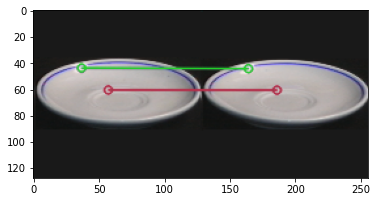

In [27]:
#detectons l'image de cette classe qui avait la plus grande similarité
if "not_found" in detected_class:
  print( "acune image correspondante")
else:
  for key in test_sorted_similarities: 
    if detected_class+'_' in key:
      good=my_match(des_img_test,descriptors[key])
      todisplay = cv.drawMatchesKnn(cv.imread(img_test),kp_img_test,train_images[key],keypoints[key],good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
      plt.imshow(todisplay),plt.show()
      break
      


In [28]:
#prediction pour matrix de confusion
def evaluate():
  predictions=[0]*len(test_images)
  true_labels=[0]*len(test_images)
  n_compteur=0
  with tqdm(total=len(test_images), desc="Prediction", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    for n_key in test_descriptors:
      current_similarities=get_similarities(test_keypoints[n_key],test_descriptors[n_key],seuil=0.60)
      current_sorted_similarities=get_sorted_similarities(current_similarities)
      current_k_classes=get_classes(current_sorted_similarities,5)
      current_detected_class=get_detected_class(current_k_classes)
      if "not_found" in current_detected_class:
        current_detected_class=0 
      else:
        predictions[n_compteur]=current_detected_class
        true_labels[n_compteur]=(n_key.split('/')[2]).split('_')[0]
        n_compteur+=1
      pbar.update(1)
    return np.array(predictions),np.array(true_labels)

In [29]:
#calcul des prédiction de tous les images test
predictions,true_labels=evaluate();

Prediction: 100%|██████████ [ time left: 00:00 ]


In [30]:
#enregistrement des predictions et labels test dans un fichier
# enregistrement des descripteurs train et test
with open("models/sift_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file, pickle.HIGHEST_PROTOCOL)
with open("models/sift_true_labels.pickle", "wb") as file:
    pickle.dump(true_labels, file, pickle.HIGHEST_PROTOCOL)

In [31]:
#chargement des predictions et true labels
with open("models/sift_predictions.pickle", "rb") as file:
    predictions = pickle.load(file)
with open("models/sift_true_labels.pickle", "rb") as file:
    true_labels = pickle.load(file)

In [32]:
print(np.unique(true_labels))

['0' 'obj1' 'obj10' 'obj100' 'obj11' 'obj12' 'obj13' 'obj14' 'obj15'
 'obj16' 'obj17' 'obj18' 'obj19' 'obj2' 'obj20' 'obj21' 'obj22' 'obj23'
 'obj24' 'obj25' 'obj26' 'obj27' 'obj28' 'obj29' 'obj3' 'obj30' 'obj31'
 'obj32' 'obj33' 'obj34' 'obj35' 'obj36' 'obj37' 'obj38' 'obj39' 'obj4'
 'obj40' 'obj41' 'obj42' 'obj43' 'obj44' 'obj45' 'obj46' 'obj47' 'obj48'
 'obj49' 'obj5' 'obj50' 'obj51' 'obj52' 'obj53' 'obj54' 'obj55' 'obj56'
 'obj57' 'obj58' 'obj59' 'obj6' 'obj60' 'obj61' 'obj62' 'obj63' 'obj64'
 'obj65' 'obj66' 'obj67' 'obj68' 'obj69' 'obj7' 'obj70' 'obj71' 'obj72'
 'obj73' 'obj74' 'obj75' 'obj76' 'obj77' 'obj78' 'obj79' 'obj8' 'obj80'
 'obj81' 'obj82' 'obj83' 'obj84' 'obj85' 'obj86' 'obj87' 'obj88' 'obj89'
 'obj9' 'obj90' 'obj91' 'obj92' 'obj93' 'obj94' 'obj95' 'obj96' 'obj97'
 'obj98' 'obj99']


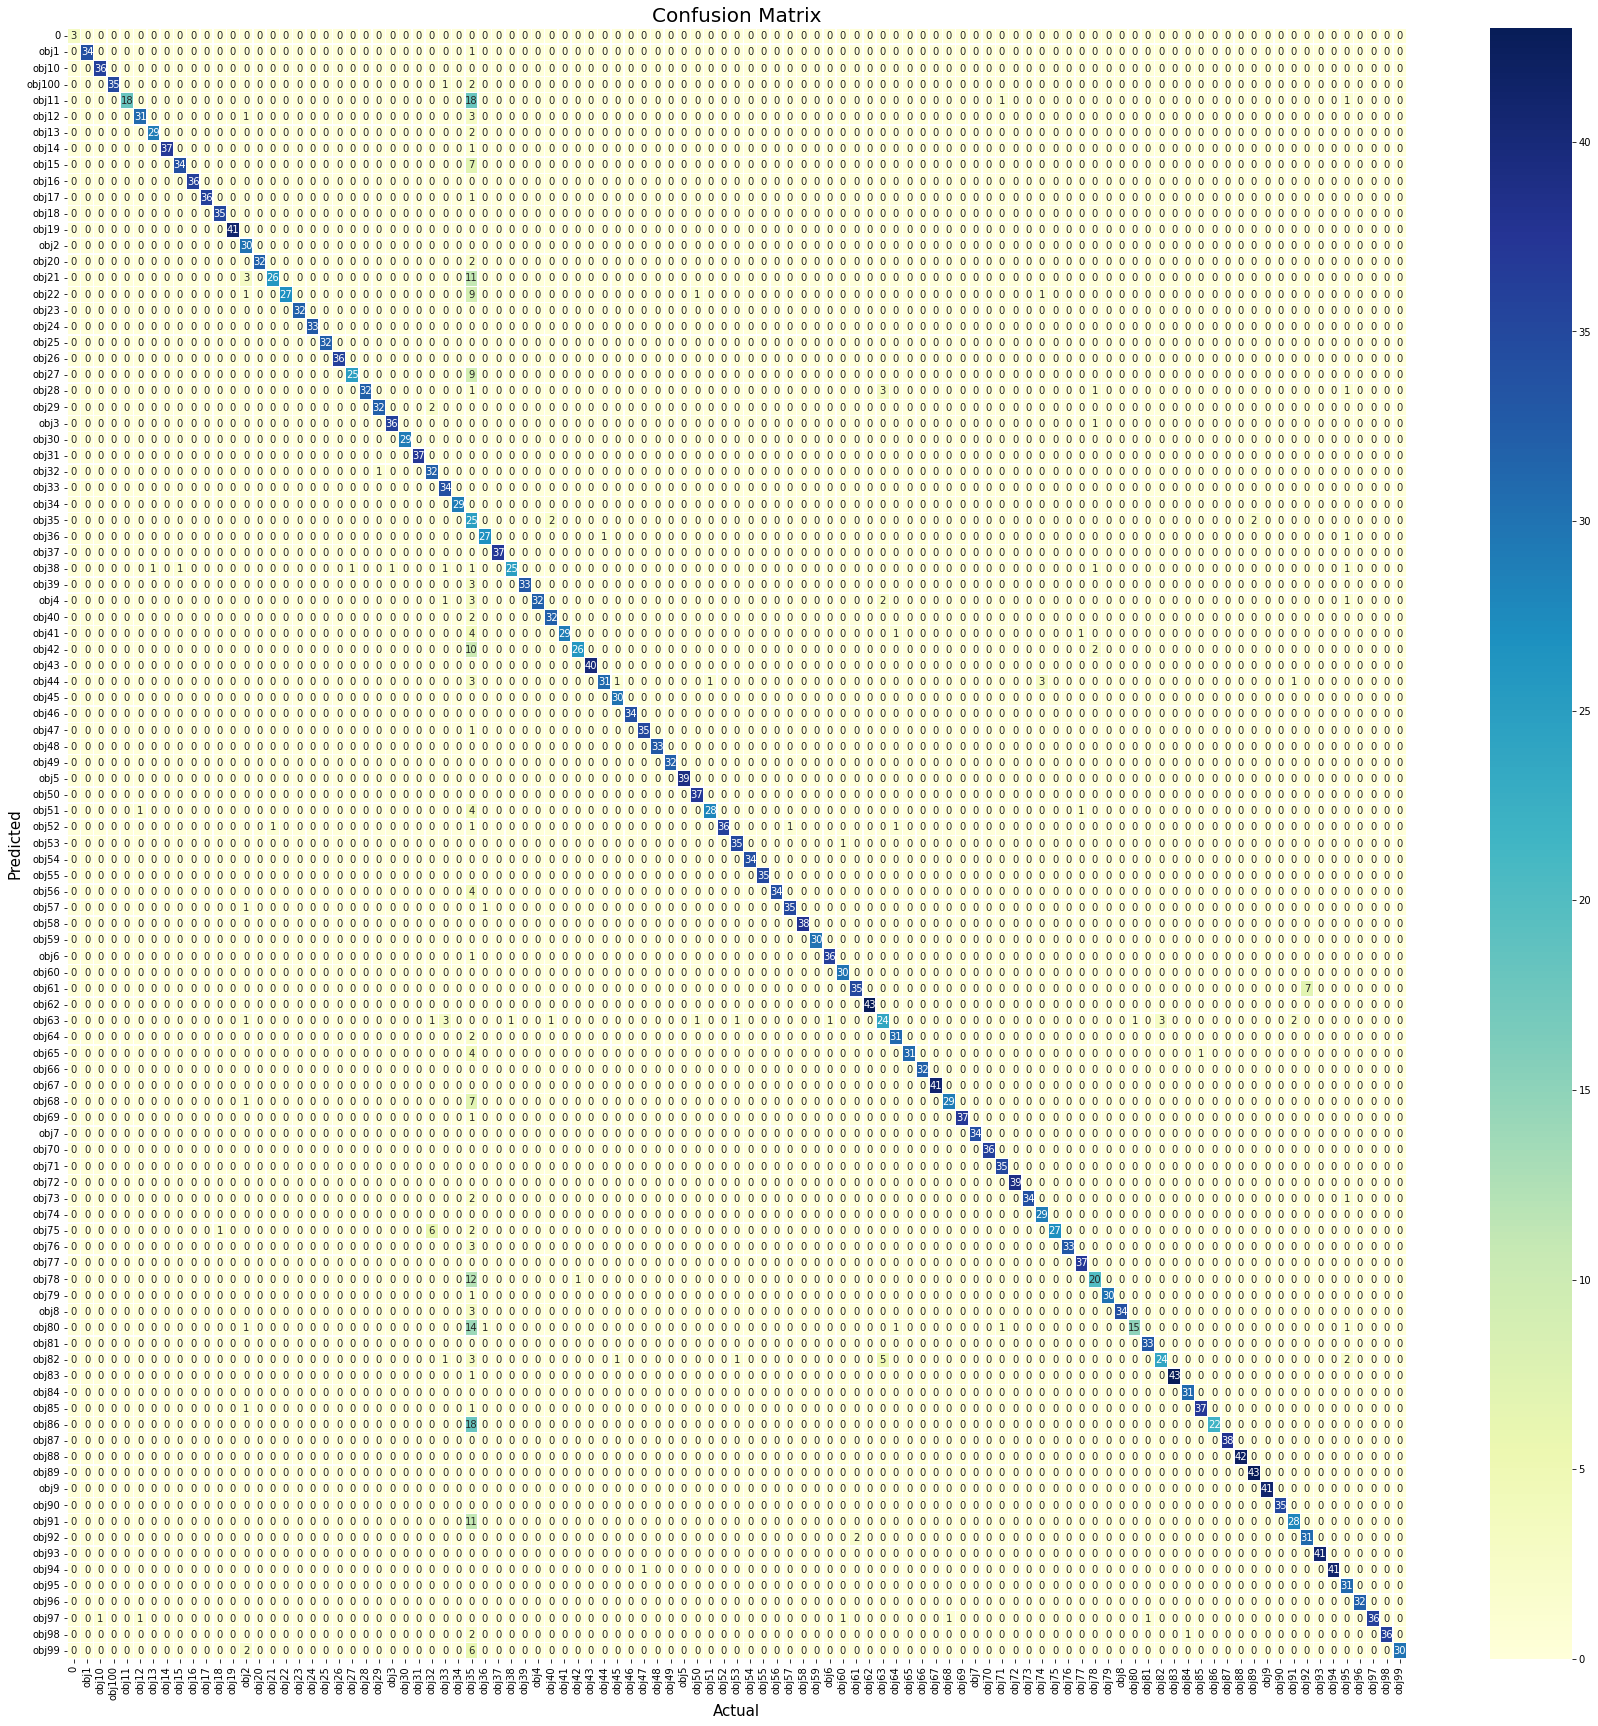

In [33]:
confm = confusion_matrix(true_labels,predictions)

df_cm = pd.DataFrame(confm, index = [i for i in np.unique(true_labels)],
              columns = [i for i in np.unique(true_labels)])

plt.figure(figsize = (30,30))
plt.title('Confusion Matrix', fontsize = 20)
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", linewidths=.5)
plt.xlabel('Actual', fontsize = 15) 
plt.ylabel('Predicted', fontsize = 15) 
plt.show()

In [34]:
print(classification_report(predictions, true_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
        obj1       0.97      1.00      0.99        34
       obj10       1.00      0.97      0.99        37
      obj100       0.92      1.00      0.96        35
       obj11       0.47      1.00      0.64        18
       obj12       0.89      0.94      0.91        33
       obj13       0.94      0.97      0.95        30
       obj14       0.97      1.00      0.99        37
       obj15       0.83      0.97      0.89        35
       obj16       1.00      1.00      1.00        36
       obj17       0.97      1.00      0.99        36
       obj18       1.00      0.97      0.99        36
       obj19       1.00      1.00      1.00        41
        obj2       1.00      0.71      0.83        42
       obj20       0.94      1.00      0.97        32
       obj21       0.65      0.96      0.78        27
       obj22       0.69      1.00      0.82        27
       obj23       1.00    